In [1]:
import pandas as pd
from nltk.corpus import stopwords
import re
import spacy
import matplotlib.pyplot as plt
nlp = spacy.load('en_core_web_sm')
df = pd.read_excel(r"C:\Users\follm\Documents\coding\music-blog-analyzer\scraping\Pitchfork Albums\page 1 to 100001 data scraping_2020-01-10.xlsx")

In [2]:
df['genre_split'] = df['genre'].apply(lambda x: [] if pd.isnull(x) else eval(x))
unique_genres = set([genre for list_of_genres in df['genre_split'].tolist() for genre in list_of_genres])
for genre in unique_genres:
    df[genre] = df['genre_split'].apply(lambda x: genre in x)

In [3]:
df_counts = pd.DataFrame([unique_genres,[sum(df[genre]) for genre in unique_genres]]).T
df_counts.columns=['Category','Count']
df_counts.describe()

,Category,Count
count,9,9
unique,9,9
top,Folk/Country,2238
freq,1,1


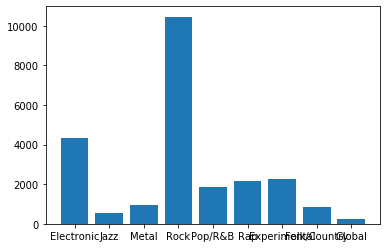

In [4]:
plt.bar(x=df_counts.Category, height=df_counts.Count)
plt.show()

In [5]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def clean_description(x):
    x = eval(x)
    text = ' '.join([pp for pp in x if not re.search('^Buy: |Pitchfork may .* affiliate', pp)]).lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    text = ' '.join(tok.lemma_ for tok in nlp(text))
    return text

df['body_clean'] = df['body'].apply(lambda x: clean_description(x))

In [8]:
df_counts.Category

0      Electronic
1            Jazz
2           Metal
3            Rock
4         Pop/R&B
5             Rap
6    Experimental
7    Folk/Country
8          Global
Name: Category, dtype: object

In [9]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[df_counts.Category.tolist() + ['body_clean']], random_state=11, test_size=0.25, shuffle=True)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(train['body_clean'])
vectorizer.fit(test['body_clean'])
x_train = vectorizer.transform(train['body_clean'])
y_train = train.drop(labels = ['body_clean'], axis=1)
x_test = vectorizer.transform(test['body_clean'])
y_test = test.drop(labels = ['body_clean'], axis=1)





In [10]:
# https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])
for category in df_counts.Category:
    print('**Processing {} ...**'.format(category))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(x_train, train[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print("\n")


**Processing Electronic ...**
Test accuracy is 0.8108794197642792


**Processing Jazz ...**
Test accuracy is 0.9746146872166818


**Processing Metal ...**
Test accuracy is 0.9537624660018132


**Processing Rock ...**
Test accuracy is 0.8181323662737987


**Processing Pop/R&B ...**
Test accuracy is 0.9185856754306437


**Processing Rap ...**
Test accuracy is 0.9053490480507707


**Processing Experimental ...**
Test accuracy is 0.9075249320036265


**Processing Folk/Country ...**
Test accuracy is 0.9639165911151405


**Processing Global ...**
Test accuracy is 0.9902085222121487




In [24]:
beg
end = 7


20